# Ammunition Time Series Forecasting and Prediction Using ARIMA, SARIMA, and SARIMAX
An in depth study into hourly ammunition price data.
#### <wyattcupp@gmail.com>
#### <wyattcupp@utexas.edu>

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as stattools
import statsmodels.tsa.arima.model as models
import pmdarima as pm

import json

%matplotlib inline

In [2]:
%conda install -c conda-forge pmdarima 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.9.0
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


## ARIMA, SARIMA, SARIMAX

**ARIMA**
- `p`: Represents number of lag observations (lag order)
- `q`: Represents the size of the moving average window, or the order of the moving average component. This refers to the number of lagged forecast errors the model uses.

TODO: Add equations and relevant background information.

## 9mm

### Data & Preprocessing

Data scraped from [Ammo Prices Now](https://ammopricesnow.com).

**Considerations**
- Data does not specify ammunition grade.
- Data only goes back to 2020, which means it may lack seasonality that would otherwise exist if it went back further.

In [92]:
# Load raw 9mm data scraped from AmmoPricesNow
nine_data_raw = None

with open('data/9mm_hourly.json') as f:
    nine_data_raw = json.load(f)

# spot check raw data
for date_, ppr in zip(nine_data_raw['categories'][:10], nine_data_raw['data'][:10]):
    print(date_, '->', ppr)

06/07/2020 06:00 -> 0.18
06/07/2020 07:00 -> 0.18
06/07/2020 08:00 -> 0.18
06/07/2020 09:00 -> 0.18
06/07/2020 10:00 -> 0.18
06/07/2020 11:00 -> 0.18
06/07/2020 12:00 -> 0.22
06/07/2020 13:00 -> 0.18
06/07/2020 14:00 -> 0.22
06/07/2020 15:00 -> 0.22


In [93]:
df_9 = pd.DataFrame(nine_data_raw).set_axis(['ppr', 'date_time'], axis=1)
df_9['date_time'] = pd.to_datetime(df_9['date_time'])

# reindex to date for time-series analysis
df_9 = df_9.set_index('date_time')

df_9.head()

,ppr
date_time,
2020-06-07 06:00:00,0.18
2020-06-07 07:00:00,0.18
2020-06-07 08:00:00,0.18
2020-06-07 09:00:00,0.18
2020-06-07 10:00:00,0.18


In [88]:
df_9.describe()

,ppr
count,29458.000000
mean,0.313995
std,0.152300
min,0.000000
25%,0.180000
50%,0.290000
75%,0.390000
max,0.710000


In [94]:
# Calculate rolling weekly statistics for better visualization
df_9['rolling_mean'] = df_9['ppr'].rolling(168).mean()
df_9['rolling_std'] = df_9['ppr'].rolling(168).std()

df_9.sample(n=10, random_state=1)

,ppr,rolling_mean,rolling_std
date_time,,,
2022-08-08 16:00:00,0.24,0.238214,0.016317
2022-02-17 13:00:00,0.30,0.296845,0.004661
2021-10-29 18:00:00,0.32,0.318512,0.018528
2023-11-19 06:00:00,0.19,0.192679,0.004442
2023-09-27 12:00:00,0.18,0.178274,0.009024
2022-01-06 16:00:00,0.29,0.288333,0.019351
2021-07-15 19:00:00,0.34,0.362917,0.013148
2022-11-19 02:00:00,0.21,0.208036,0.014611
2020-12-27 20:00:00,0.46,0.527857,0.046289


In [95]:
# check if we are missing any data, and if so, impute it
df_9['ppr'].isna().sum()

0

### Analysis

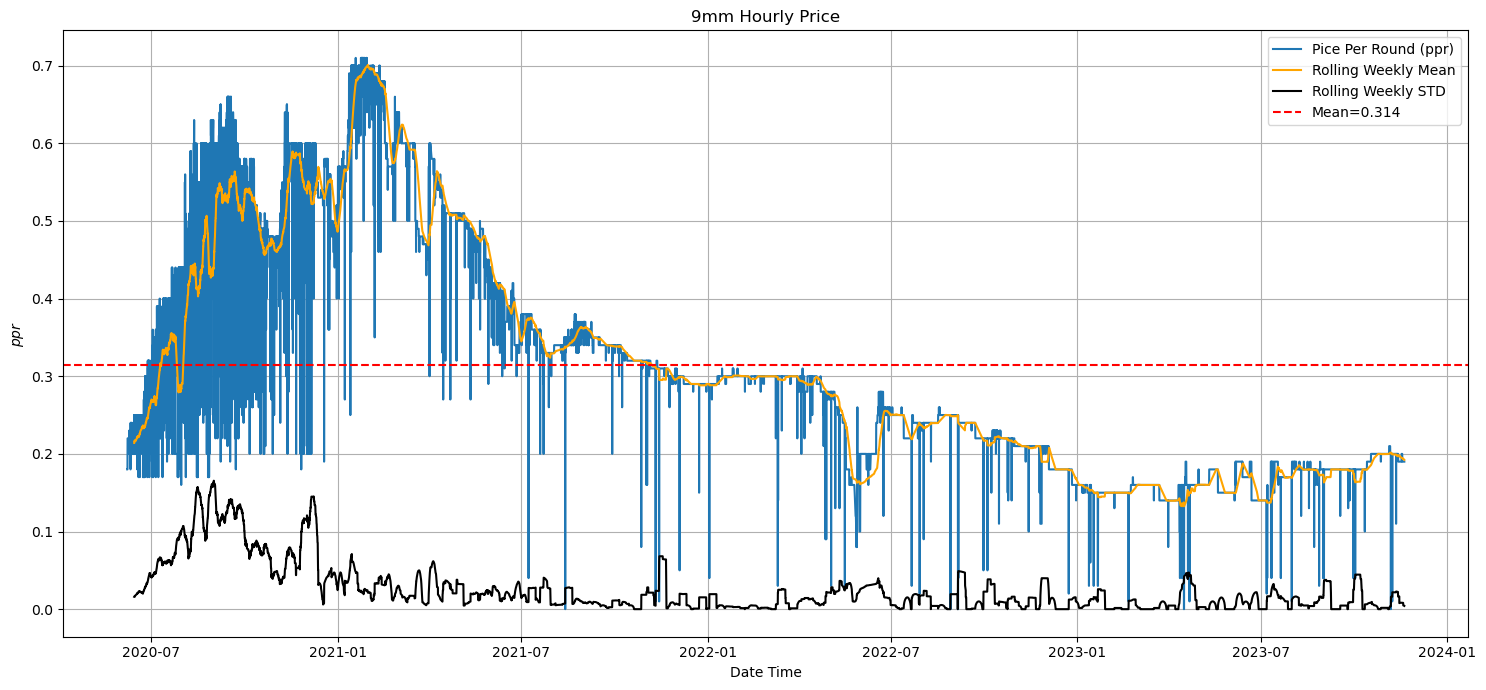

In [64]:
plt.figure(figsize=(15,7))

# plot ppr over time
plt.plot(df_9['ppr'], label='Pice Per Round (ppr)')
# plot weekly rolling average and std
plt.plot(df_9['rolling_mean'], color='orange', label='Rolling Weekly Mean')
plt.plot(df_9['rolling_std'], color='black', label='Rolling Weekly STD')

# plot the mean horizontally
plt.axhline(df_9['ppr'].mean(), color='r', ls='--', label=f'Mean={df_9["ppr"].mean():.3f}')

plt.title('9mm Hourly Price')
plt.legend()
plt.grid()

# Axis labels
plt.xlabel('Date Time')
plt.ylabel('$ppr$')

plt.tight_layout()
plt.show()

#### Augmented Dickey-Fuller Test (ADF)

Used to determine if time-series data is stationary or not.

**Null Hypothesis**: Data is not stationary.

**Alternative Hyptothesis**: Data **is** stationary.

**Significance Level**: 0.05

To reject the null hypothesis, the ADF test should have
- p-value <= 0.05

In [105]:
import statsmodels.tsa.stattools as stattools

#Augmented Dickey–Fuller test
adf_result_raw = stattools.adfuller(df_9['ppr'], autolag='AIC')

adf_result = {
    "Test Statistic": adf_result_raw[0],
    "p-value": adf_result_raw[1],
    "# Lags Used": adf_result_raw[2],
    "# Observations Used": adf_result_raw[3]
}

for k,v in adf_result_raw[4].items():
    adf_result[f'Critical Value ({k})'] = v

adf_result

{'Test Statistic': -2.0167218100444018,
 'p-value': 0.27928963841542853,
 '# Lags Used': 50,
 '# Observations Used': 29407,
 'Critical Value (1%)': -3.430572391638328,
 'Critical Value (5%)': -2.8616382910200167,
 'Critical Value (10%)': -2.5668223173231364}

Considering our p-value >=0.05, we can assume our data is not stationary.

#### ARIMA Model

Even though our data is not stationary, we will first attempt to use an ARIMA model, which doesn't take into account seasonality using the following workflow:
- Use `pmdarima`'s `auto_arima` to pull the optimal `order` for our model.
- Fit a `statsmodels.tsa.arima.ARIMA` model using the optimized `order` found in the previous step.

In [106]:
# Auto-Arima model
auto_ARIMA = pm.auto_arima(df_9['ppr'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='ignore', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

/Users/wyattcupp/miniconda3/envs/ds-py311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/wyattcupp/miniconda3/envs/ds-py311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/wyattcupp/miniconda3/envs/ds-py311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/wyattcupp/miniconda3/envs/ds-py311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future 

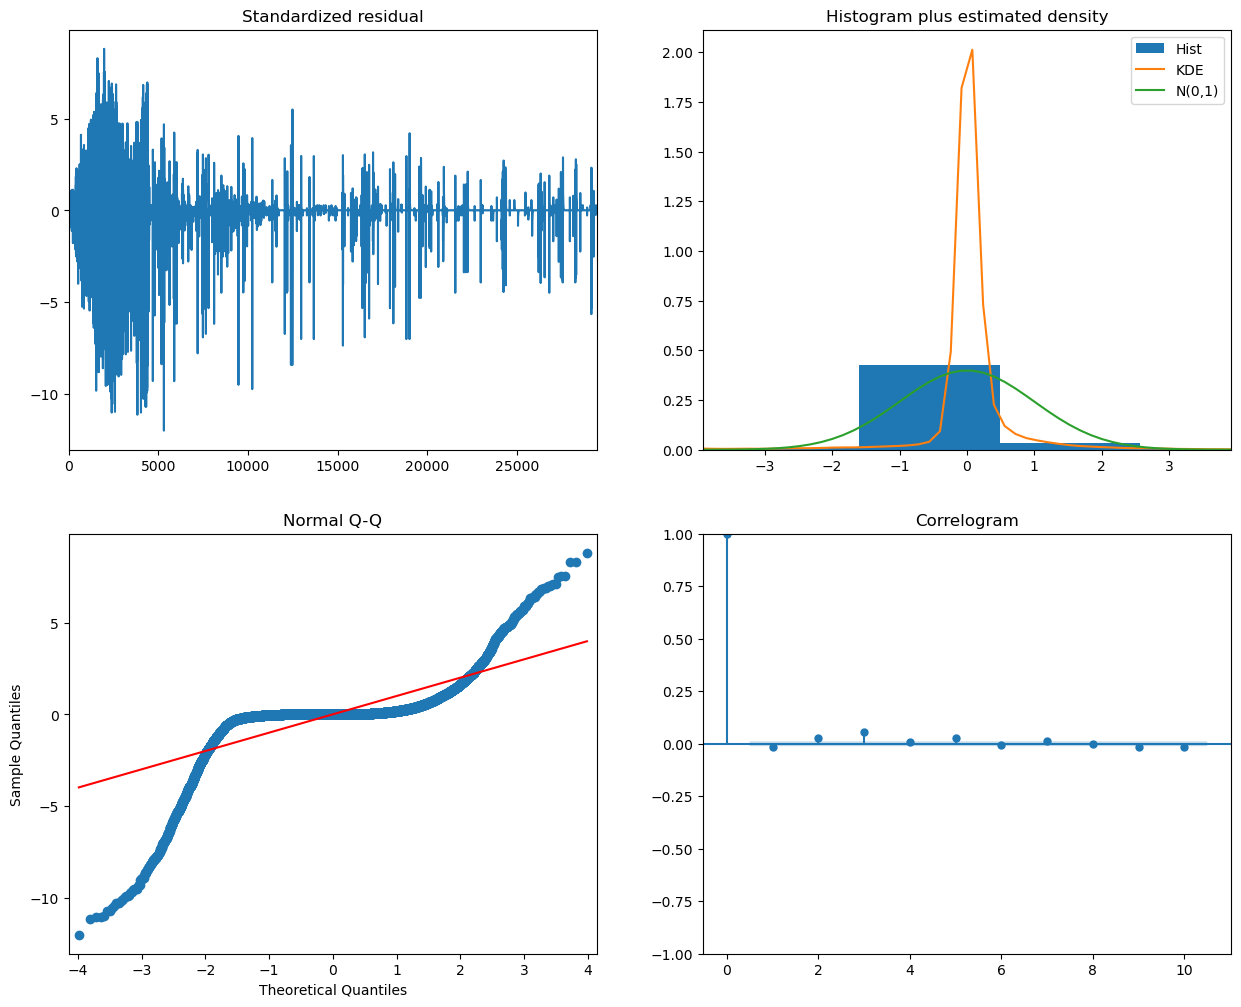

In [107]:
auto_ARIMA.plot_diagnostics(figsize=(15,12))
plt.show()

In [109]:
auto_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                29458
Model:               SARIMAX(2, 0, 1)   Log Likelihood               56452.944
Date:                Fri, 01 Dec 2023   AIC                        -112897.888
Time:                        19:50:09   BIC                        -112864.725
Sample:                             0   HQIC                       -112887.238
                              - 29458                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3511      0.002    681.821      0.000       1.347       1.355
ar.L2         -0.3511      0.002   -178.500      0.000      -0.355      -0.347
ma.L1         -0.9295      0.001   -999.668      0.000      -0.931      -0.928
sigma2         0.0013   3.24e-06    391.021      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   8.73   Jarque-Bera (JB):           1594225.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                            -3.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [110]:
# check optimized order outputs (seasonal order should be zeros, since we are using ARIMA only and not SARIMA/SARIMAX)
auto_ARIMA.order, auto_ARIMA.seasonal_order

((2, 0, 1), (0, 0, 0, 0))

#### Now we fit an ARIMA base model using the optimized order from `auto_arima`

In [119]:
arima_model = models.ARIMA(df_9['ppr'], order=auto_ARIMA.order, seasonal_order=(0,0,0,0))

arima_fitted = model.fit()

arima_fitted.summary()

/Users/wyattcupp/miniconda3/envs/ds-py311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/wyattcupp/miniconda3/envs/ds-py311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/wyattcupp/miniconda3/envs/ds-py311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    ppr   No. Observations:                29458
Model:                 ARIMA(2, 0, 1)   Log Likelihood               56455.690
Date:                Fri, 01 Dec 2023   AIC                        -112901.381
Time:                        19:58:41   BIC                        -112859.927
Sample:                             0   HQIC                       -112888.068
                              - 29458                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3132      0.120      2.621      0.009       0.079       0.547
ar.L1          1.3506      0.002    658.362      0.000       1.347       1.355
ar.L2         -0.3508      0.002   -174.603      0.000      -0.355      -0.347
ma.L1         -0.9291      0.001   -981.210      0.000      -0.931      -0.927
sigma2         0.0013   3.39e-06    373.953      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   8.72   Jarque-Bera (JB):           1581211.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                            -3.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### TODO - Predictions and Forecasting

In [120]:
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df_9.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='H')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df_9["ppr"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA PPR Forecast")
    plt.show()

#### SARIMA Model

In [134]:
(365*24) / 4

2190.0

In [139]:
import statsmodels.tsa.seasonal as seasonal

# First, we need to find the optimal seasonal periodicity of our data using seasonal decomposition
HRS_IN_DAY = 24
HRS_IN_WK = HRS_IN_DAY * 7
HRS_IN_YR = HRS_IN_DAY * 365
HRS_IN_QTR = int(HRS_IN_YR / 4)

seasonal_periods = [HRS_IN_DAY, HRS_IN_WK, HRS_IN_YR, HRS_IN_QTR]

decompositions = {}
for period in seasonal_periods:
    result = seasonal.seasonal_decompose(df_9['ppr'], model='additive', period=period)
    decompositions[period] = result

period 24
period 168
period 8760
period 2190


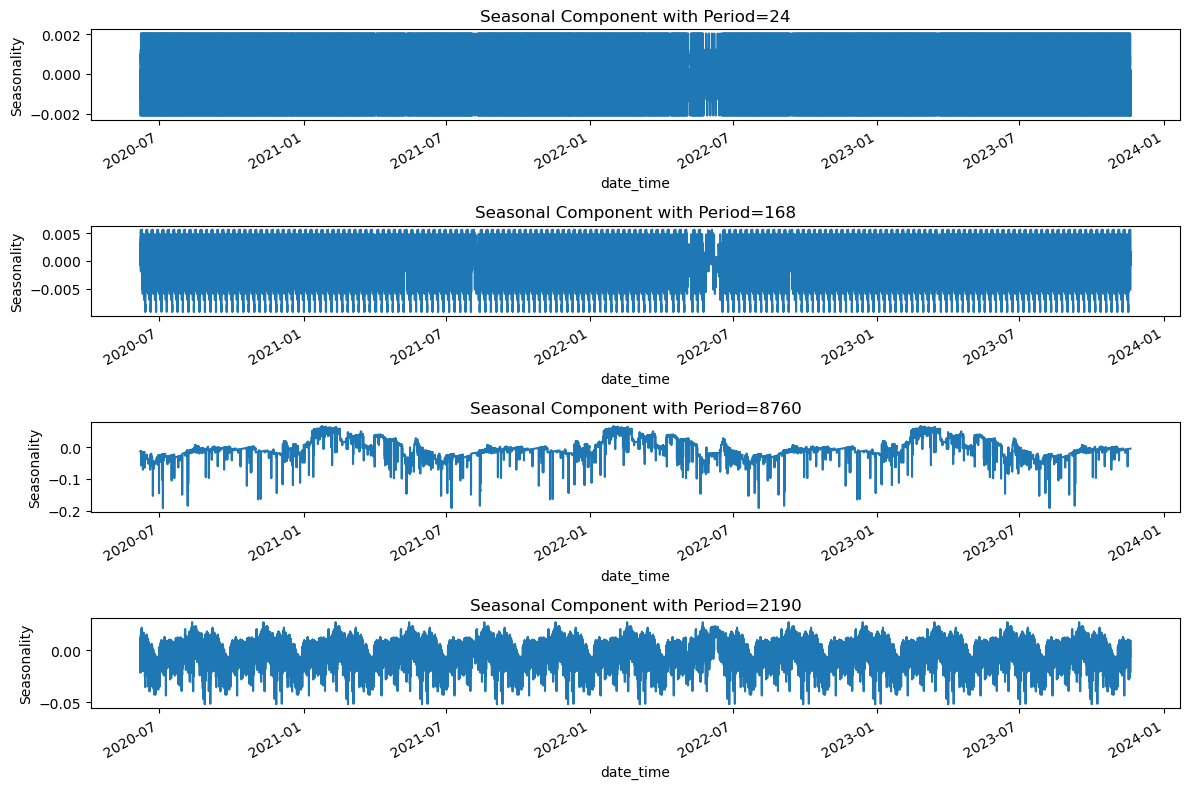

In [140]:
fig, axes = plt.subplots(nrows=len(seasonal_periods), figsize=(12, 8))

for i, period in enumerate(seasonal_periods):
    decompositions[period].seasonal.plot(ax=axes[i])
    axes[i].set_title(f'Seasonal Component with Period={period}')
    axes[i].set_ylabel('Seasonality')

plt.tight_layout()
plt.show()

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
auto_SARIMA = pm.auto_arima(df_9['ppr'],
                            start_p=1,
                            start_q=1,
                            test='adf',
                            max_p=3,
                            max_q=3, 
                            # m=12, #12 is the frequncy of the cycle
                            start_P=0, 
                            seasonal=True, #set to seasonal
                            d=None, 
                            D=1, #order of the seasonal differencing
                            trace=False,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

In [44]:
# use stattools ARIMA model

import statsmodels.tsa.arima as arima

model = arima.model.ARIMA(df_9['ppr'], order=(1,1,1))

/Users/wyattcupp/miniconda3/envs/ds-py311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/wyattcupp/miniconda3/envs/ds-py311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/wyattcupp/miniconda3/envs/ds-py311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [45]:
model_fit = model.fit()



model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    ppr   No. Observations:                29458
Model:                 ARIMA(1, 1, 1)   Log Likelihood               56452.593
Date:                Fri, 01 Dec 2023   AIC                        -112899.186
Time:                        17:33:42   BIC                        -112874.314
Sample:                             0   HQIC                       -112891.198
                              - 29458                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3511      0.002    191.912      0.000       0.348       0.355
ma.L1         -0.9295      0.001  -1001.951      0.000      -0.931      -0.928
sigma2         0.0013   2.52e-06    502.610      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   8.75   Jarque-Bera (JB):           1597041.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                            -3.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

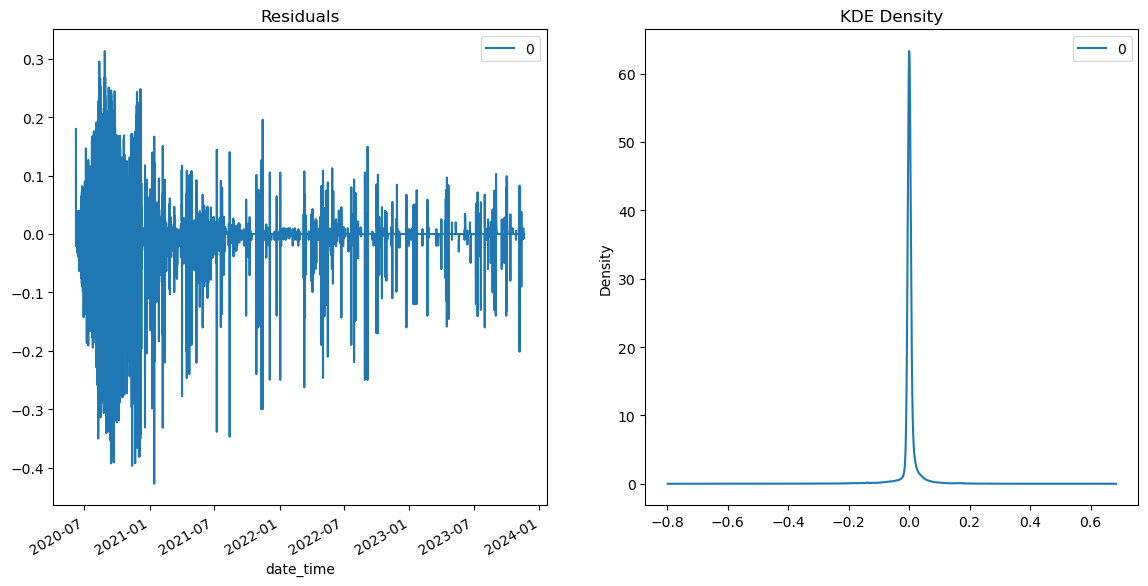

In [46]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='KDE Density', ax=ax[1])
plt.show()

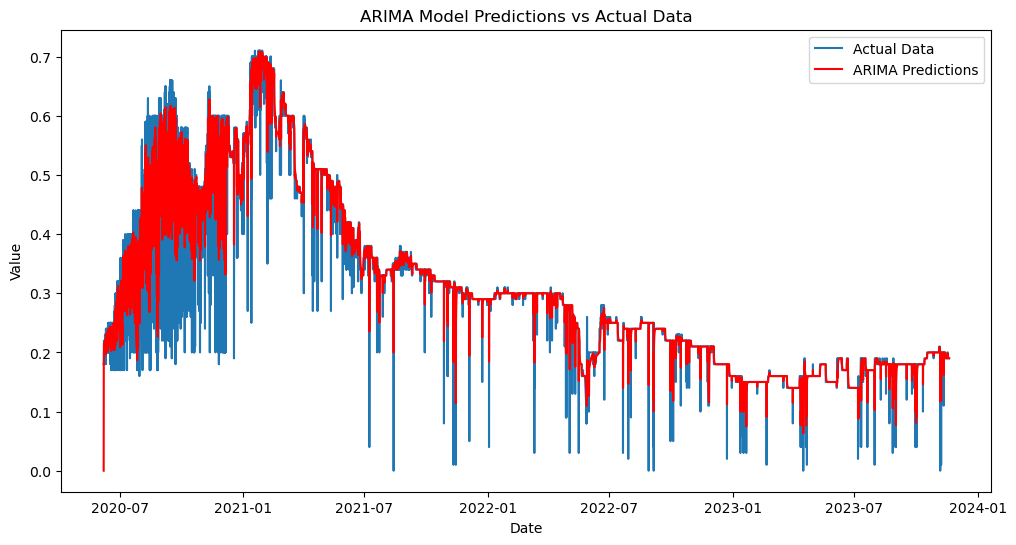

In [47]:
preds = model_fit.predict(start=df_9.index[0], end=df_9.index[-1])

plt.figure(figsize=(12, 6))
plt.plot(df_9['ppr'], label='Actual Data')
plt.plot(preds, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model Predictions vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


## 223 Remington

### Data

In [75]:
rem_data_raw = None

with open('data/223rem_hourly.json') as f:
    rem_data_raw = json.load(f)

# spot check raw data
for date_, ppr in zip(rem_data_raw['categories'][:10], rem_data_raw['data'][:10]):
    print(date_, '->', ppr)

06/07/2020 06:00 -> 0.32
06/07/2020 07:00 -> 0.32
06/07/2020 08:00 -> 0.32
06/07/2020 09:00 -> 0.32
06/07/2020 10:00 -> 0.32
06/07/2020 11:00 -> 0.32
06/07/2020 12:00 -> 0.32
06/07/2020 13:00 -> 0.32
06/07/2020 14:00 -> 0.32
06/07/2020 15:00 -> 0.32


In [76]:
df_223 = pd.DataFrame(rem_data_raw).set_axis(['ppr', 'date_time'], axis=1)
df_223['date_time'] = pd.to_datetime(df_223['date_time'])
df_223 = df_223.set_index('date_time')

df_223.head()

,ppr
date_time,
2020-06-07 06:00:00,0.32
2020-06-07 07:00:00,0.32
2020-06-07 08:00:00,0.32
2020-06-07 09:00:00,0.32
2020-06-07 10:00:00,0.32


In [102]:
df_223.describe()

,ppr,rolling_mean,rolling_std
count,29475.000000,29308.000000,29308.000000
mean,0.461013,0.461407,0.021631
std,0.146162,0.142769,0.024316
min,0.000000,0.274821,0.000000
25%,0.340000,0.339226,0.003629
50%,0.430000,0.431786,0.013584
75%,0.530000,0.540208,0.031623
max,1.060000,0.927083,0.159099


In [96]:
# Calculate rolling weekly statistics for better visualization
df_223['rolling_mean'] = df_223['ppr'].rolling(168).mean()
df_223['rolling_std'] = df_223['ppr'].rolling(168).std()

df_223.sample(n=10, random_state=1)

,ppr,rolling_mean,rolling_std
date_time,,,
2020-09-14 06:00:00,0.59,0.588810,0.058941
2021-01-05 20:00:00,0.70,0.692976,0.037313
2021-11-14 18:00:00,0.45,0.449881,0.001543
2021-03-25 06:00:00,0.70,0.675833,0.030138
2023-06-24 05:00:00,0.33,0.329286,0.009258
2020-07-09 18:00:00,0.45,0.406012,0.031833
2021-04-28 17:00:00,0.67,0.677560,0.014497
2022-08-01 17:00:00,0.41,0.411667,0.003738
2020-11-08 23:00:00,0.70,0.664643,0.039532


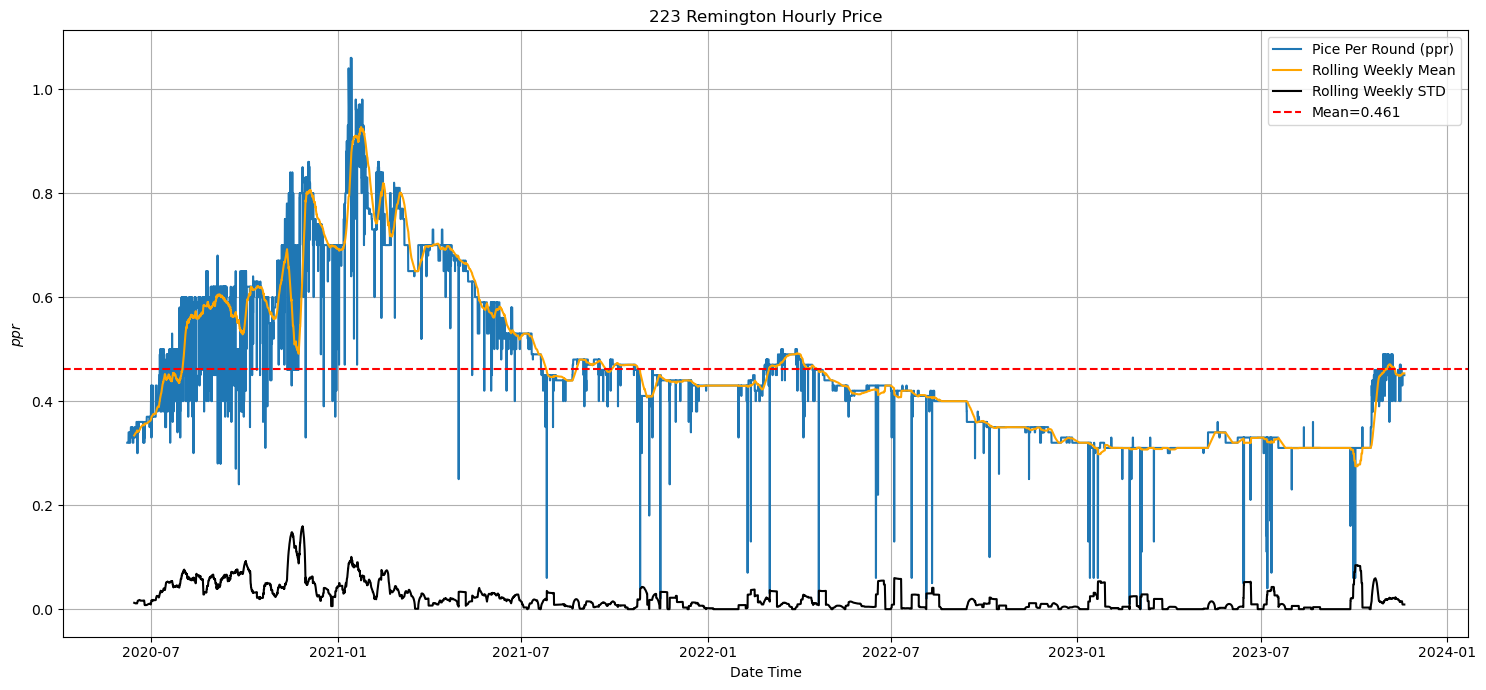

In [97]:
plt.figure(figsize=(15,7))

# plot ppr over time
plt.plot(df_223['ppr'], label='Pice Per Round (ppr)')
# plot weekly rolling average and std
plt.plot(df_223['rolling_mean'], color='orange', label='Rolling Weekly Mean')
plt.plot(df_223['rolling_std'], color='black', label='Rolling Weekly STD')

# plot the mean horizontally
plt.axhline(df_223['ppr'].mean(), color='r', ls='--', label=f'Mean={df_223["ppr"].mean():.3f}')

plt.title('223 Remington Hourly Price')
plt.legend()
plt.grid()

# Axis labels
plt.xlabel('Date Time')
plt.ylabel('$ppr$')

plt.tight_layout()
plt.show()

## 556 NATO

### Data

In [77]:
nato_data_raw = None

with open('data/556nato_hourly.json') as f:
    nato_data_raw = json.load(f)

# spot check raw data
for date_, ppr in zip(nato_data_raw['categories'][:10], nato_data_raw['data'][:10]):
    print(date_, '->', ppr)

03/22/2021 08:00 -> 0.77
03/22/2021 09:00 -> 0.77
03/22/2021 10:00 -> 0.77
03/22/2021 11:00 -> 0.77
03/22/2021 12:00 -> 0.7
03/22/2021 13:00 -> 0.77
03/22/2021 14:00 -> 0.77
03/22/2021 15:00 -> 0.77
03/22/2021 16:00 -> 0.77
03/22/2021 17:00 -> 0.77


In [78]:
df_556 = pd.DataFrame(nato_data_raw).set_axis(['ppr', 'date_time'], axis=1)
df_556['date_time'] = pd.to_datetime(df_556['date_time'])
df_556 = df_556.set_index('date_time')

df_556.head()

,ppr
date_time,
2021-03-22 08:00:00,0.77
2021-03-22 09:00:00,0.77
2021-03-22 10:00:00,0.77
2021-03-22 11:00:00,0.77
2021-03-22 12:00:00,0.70


In [101]:
df_556.describe()

,ppr,rolling_mean,rolling_std
count,22509.000000,22342.000000,22342.000000
mean,0.436217,0.434705,0.015675
std,0.112601,0.108644,0.016427
min,0.000000,0.220833,0.000000
25%,0.350000,0.347976,0.003790
50%,0.440000,0.441429,0.009636
75%,0.500000,0.498810,0.024456
max,0.790000,0.774107,0.094485


In [98]:
# Calculate rolling weekly statistics for better visualization
df_556['rolling_mean'] = df_556['ppr'].rolling(168).mean()
df_556['rolling_std'] = df_556['ppr'].rolling(168).std()

df_556.sample(n=10, random_state=1)

,ppr,rolling_mean,rolling_std
date_time,,,
2021-04-12 17:00:00,0.75,0.758571,0.058701
2023-07-28 05:00:00,0.37,0.370000,0.000000
2021-08-26 21:00:00,0.54,0.511429,0.029472
2023-05-06 11:00:00,0.35,0.350000,0.000000
2022-02-22 21:00:00,0.45,0.450000,0.000000
2022-07-13 12:00:00,0.43,0.437976,0.009700
2022-08-05 14:00:00,0.43,0.430000,0.000000
2023-09-11 18:00:00,0.34,0.340000,0.000000
2021-10-22 21:00:00,0.50,0.496190,0.007076


In [100]:
df_556['ppr'].isna().sum()

0

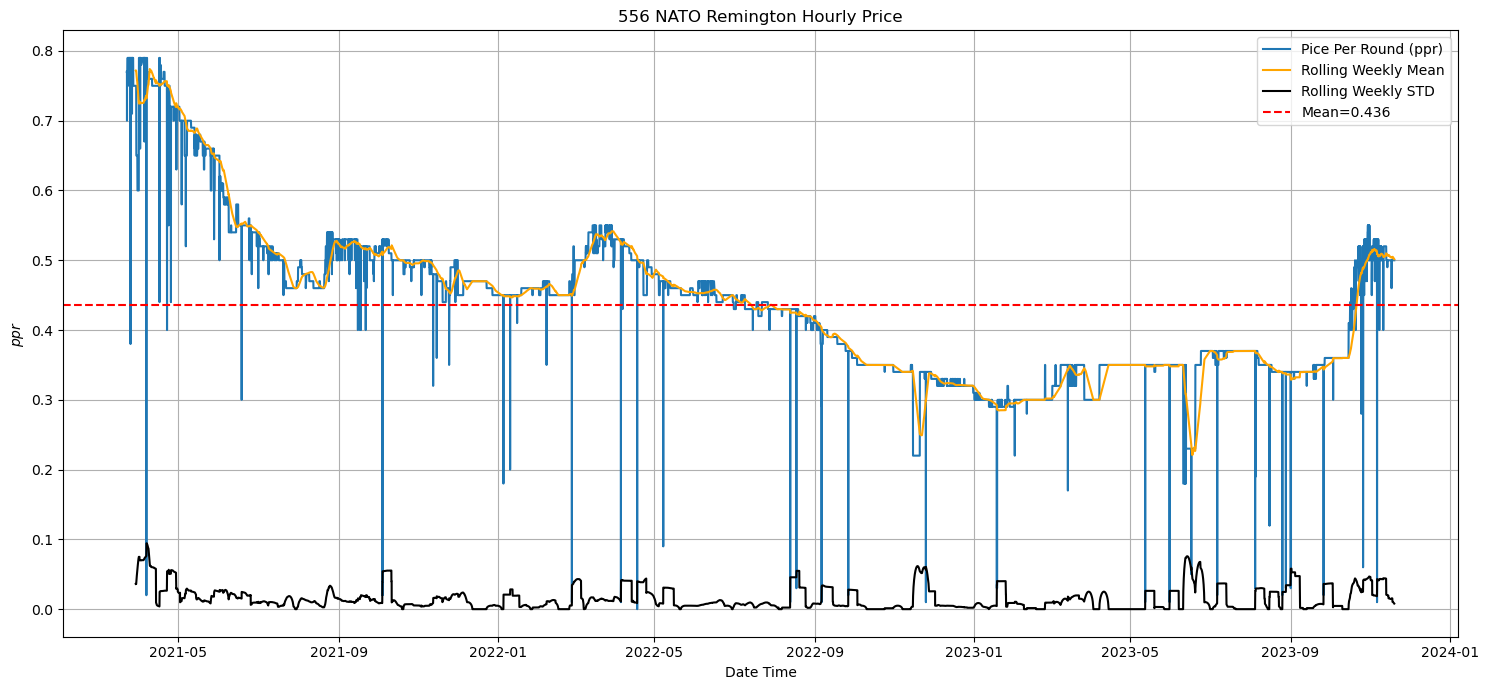

In [99]:
# 556
plt.figure(figsize=(15,7))

# plot ppr over time
plt.plot(df_556['ppr'], label='Pice Per Round (ppr)')
# plot weekly rolling average and std
plt.plot(df_556['rolling_mean'], color='orange', label='Rolling Weekly Mean')
plt.plot(df_556['rolling_std'], color='black', label='Rolling Weekly STD')

# plot the mean horizontally
plt.axhline(df_556['ppr'].mean(), color='r', ls='--', label=f'Mean={df_556["ppr"].mean():.3f}')

plt.title('556 NATO Remington Hourly Price')
plt.legend()
plt.grid()

# Axis labels
plt.xlabel('Date Time')
plt.ylabel('$ppr$')

plt.tight_layout()
plt.show()